First, the needed imports.

In [ ]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt

2024-04-09 15:26:14.849830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Session 3

In [3]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

In [9]:
import numpy as np
import os
import pickle

# Load CIFAR-10 dataset
def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data[b'data'], data[b'labels']

def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []
    for i in range(1, 6):
        filename = os.path.join(data_dir, 'data_batch_' + str(i))
        data, labels = load_cifar10_batch(filename)
        train_data.append(data)
        train_labels.append(labels)
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return train_data, train_labels, test_data, test_labels

data_dir = 'cifar-10-batches-py'  # Folder containing CIFAR-10 dataset files
x_train, y_train, x_test, y_test = load_cifar10_data(data_dir)

# Reshape and normalize data
x_train = x_train.reshape((len(x_train), 3, 32, 32)).transpose(0, 2, 3, 1)
x_test = x_test.reshape((len(x_test), 3, 32, 32)).transpose(0, 2, 3, 1)
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Convert y_test to numpy array
y_test = np.array(y_test)

# Display the shape of the datasets
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


In [10]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

In [11]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [12]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3


2024-04-09 15:32:59.525557: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incifar10_classifier/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - 12s 9ms/step - loss: 1.8022 - accuracy: 0.3380
Epoch 2/3
98/98 [==============================] - 1s 7ms/step - loss: 1.4515 - accuracy: 0.4772
Epoch 3/3
98/98 [==============================] - 1s 7ms/step - loss: 1.3194 - accuracy: 0.5307


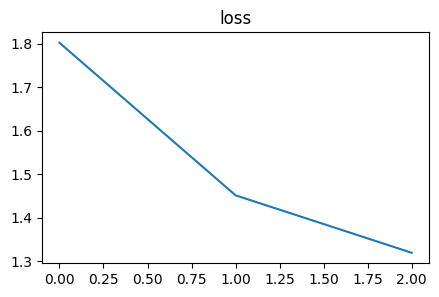

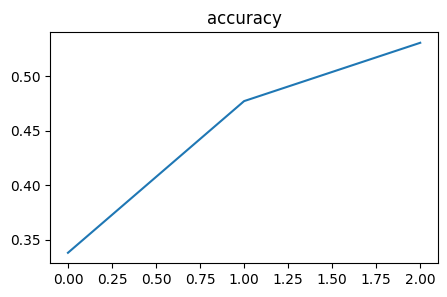

In [13]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [14]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 0s - loss: 1.1503 - accuracy: 0.5962 - 468ms/epoch - 1ms/step
accuracy: 59.62%
CPU times: user 652 ms, sys: 148 ms, total: 799 ms
Wall time: 588 ms


In [15]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 0s 801us/step
[[686  30  83  23  14   7  23  13  87  34]
 [ 37 751   9   4   7   2  30  13  41 106]
 [ 69   9 466  73 113  74 116  49  16  15]
 [ 17   8 104 391  74 146 177  51  14  18]
 [ 40   4 148  59 477  25 154  84   7   2]
 [ 14   3 114 192  59 450  72  77  12   7]
 [  5   5  47  54  55   6 803  14   4   7]
 [ 19   3  45  51  67  67  39 680   3  26]
 [157  62  26  18   3   9  23   8 650  44]
 [ 51 160  11  15   3   5  47  43  57 608]]

Classification accuracy for each class:

0: 0.6860
1: 0.7510
2: 0.4660
3: 0.3910
4: 0.4770
5: 0.4500
6: 0.8030
7: 0.6800
8: 0.6500
9: 0.6080


In [16]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [17]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [18]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [19]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 1.4 seconds for epoch #0
beginning epoch 1
took 0.6 seconds for epoch #1
beginning epoch 2
took 0.6 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.06%, although it varies randomly.

In [21]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_2 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.2)
        self.conv_5 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_6 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_7 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_8 = tf.keras.layers.Dropout(0.2)
        self.conv_9 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_10 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_11 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_12 = tf.keras.layers.Dropout(0.2)
        self.dense_13 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_14 = tf.keras.layers.Dropout(0.2)
        self.dense_15 = tf.keras.layers.Dense(10, activation='softmax')
        

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        
        x = self.conv_5(x)
        x = self.conv_6(x)
        x = self.pool_7(x)
        x = self.drop_8(x)
        
        
        x = self.conv_9(x)
        x = self.conv_10(x)
        x = self.pool_11(x)
        x = self.drop_12(x)
        
        
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_13(x)
        x = self.drop_14(x)
        x = self.dense_15(x)

        return x

In [22]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [23]:
batch_size = 64
epochs = 10
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/10


2024-04-09 15:35:28.352821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incifar10_classifier_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 [==============================] - 5s 3ms/step - loss: 1.6818 - accuracy: 0.3803
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 1.1714 - accuracy: 0.5839
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.9527 - accuracy: 0.6646
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.8331 - accuracy: 0.7084
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.7517 - accuracy: 0.7385
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.6963 - accuracy: 0.7577
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 0.6385 - accuracy: 0.7786
Epoch 8/10
782/782 [==============================] - 2s 3ms/step - loss: 0.5969 - accuracy: 0.7934
Epoch 9/10
782/782 [==============================] - 2s 3ms/step - loss: 0.5731 - accuracy: 0.7994
Epoch 10/10
782/782 [==============================] - 2s 3ms/step - loss: 0.5396 - accuracy: 0.8119


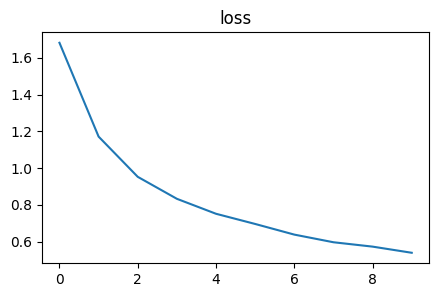

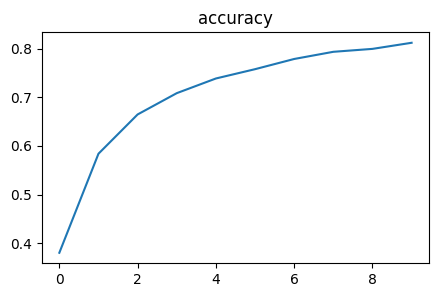

In [24]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)
Epoch 1/20
391/391 [==============================] - 6s 8ms/step - loss: 1.1282 - accuracy: 0.6094 - val_loss: 4.9675 - val_accuracy: 0.1635
Epoch 2/20
391/391 [==============================] - 2s 6ms/step - loss: 0.7077 - accuracy: 0.7534 - val_loss: 0.8873 - val_accuracy: 0.6877
Epoch 3/20
391/391 [==============================] - 2s 6ms/step - loss: 0.5043 - accuracy: 0.8248 - val_loss: 1.0173 - val_accuracy: 0.6954
Epoch 4/20
391/391 [==============================] - 2s 6ms/step - loss: 0.3437 - accuracy: 0.8807 - val_loss: 0.7856 - val_accuracy: 0.7573
Epoch 5/20
391/391 [==============================] - 2s 6ms/step - loss: 0.1826 - accuracy: 0.9390 - val_loss: 0.9030 - val_accuracy: 0.7360
Epoch 6/20
391/391 [==============================] - 2s 6ms/step - loss: 0.0877 - accuracy: 0.9736 - val_loss: 0.7434 - val_accuracy: 0.7905
Epoch 7/20
3

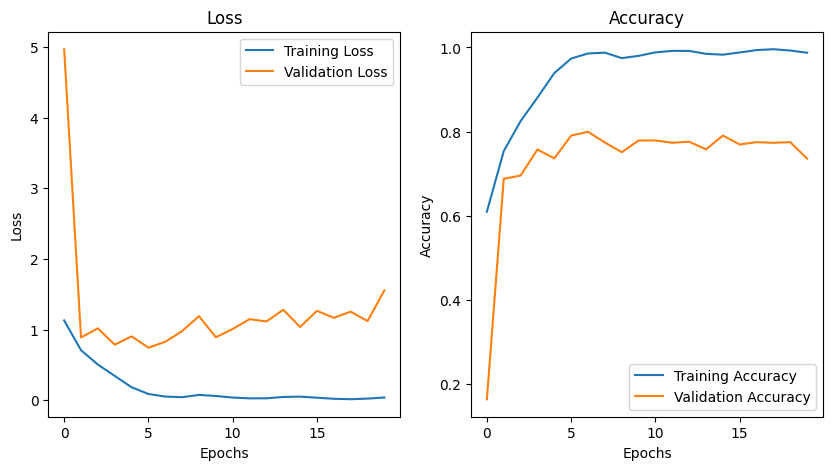

Test Loss: 1.5546932220458984
Test Accuracy: 0.7355999946594238
313/313 [==============================] - 0s 1ms/step
Confusion Matrix:
[[578  11 107  74  68  18  22  20  76  26]
 [  8 823  15  26  10  11  11   6  31  59]
 [ 22   1 649  59 128  57  45  24  12   3]
 [  4   1  53 620 115 116  52  27  11   1]
 [  3   2  30  39 869  19  17  15   5   1]
 [  1   0  42 191 106 601  22  28   7   2]
 [  1   0  42  51  80  29 782  10   5   0]
 [  5   0  25  33 137  39   7 749   3   2]
 [ 16  18  27  23  23   5  11   1 862  14]
 [  7  41  10  48  15  15   2  14  25 823]]

Classification Accuracy for Each Class:
Class 0: 0.578
Class 1: 0.823
Class 2: 0.649
Class 3: 0.62
Class 4: 0.869
Class 5: 0.601
Class 6: 0.782
Class 7: 0.749
Class 8: 0.862
Class 9: 0.823


In [25]:
# Importing necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle

# Load CIFAR-10 dataset
def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data[b'data'], data[b'labels']

def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []
    for i in range(1, 6):
        filename = os.path.join(data_dir, 'data_batch_' + str(i))
        data, labels = load_cifar10_batch(filename)
        train_data.append(data)
        train_labels.append(labels)
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return train_data, train_labels, test_data, test_labels

data_dir = 'cifar-10-batches-py'  # Folder containing CIFAR-10 dataset files
x_train, y_train, x_test, y_test = load_cifar10_data(data_dir)

# Reshape and normalize data
x_train = x_train.reshape((len(x_train), 3, 32, 32)).transpose(0, 2, 3, 1)
x_test = x_test.reshape((len(x_test), 3, 32, 32)).transpose(0, 2, 3, 1)
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Convert y_test to numpy array
y_test = np.array(y_test)

# Display the shape of the datasets
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

# Define CIFAR-10 Classifier model with batch normalization
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.conv_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.bn_3 = tf.keras.layers.BatchNormalization()
        self.conv_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.bn_4 = tf.keras.layers.BatchNormalization()
        self.pool_6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense_7 = tf.keras.layers.Dense(512, activation='relu')
        self.bn_5 = tf.keras.layers.BatchNormalization()
        self.dense_8 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.pool_3(x)
        x = self.conv_4(x)
        x = self.bn_3(x)
        x = self.conv_5(x)
        x = self.bn_4(x)
        x = self.pool_6(x)
        x = self.flatten(x)
        x = self.dense_7(x)
        x = self.bn_5(x)
        x = self.dense_8(x)
        return x

# Function to train the model
def train_network(batch_size, epochs, lr):
    model = CIFAR10Classifier()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
    return history, model

# Training parameters
batch_size = 128
epochs = 20
lr = 0.001

# Train the model
history, model = train_network(batch_size, epochs, lr)

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Confusion matrix and classification accuracy for each class
predictions = model.predict(x_test)
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis=1))
classification_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

print("Confusion Matrix:")
print(confusion_matrix.numpy())
print("\nClassification Accuracy for Each Class:")
for i, acc in enumerate(classification_accuracy):
    print(f"Class {i}: {acc}")
